# Web Scrapping Music Sites to build a Music Recommender

### Scrapping Billboard top 100

In [63]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [64]:
url = "https://www.billboard.com/charts/hot-100"
response = requests.get(url)
response.status_code
soup = BeautifulSoup(response.content,'html.parser') #Set the parser
soup.select("button.chart-element__wrapper ")[0] #information in the page code
# song name 
soup.select("span.chart-element__information span.chart-element__information__song")[0].text
# artist name 
soup.select("span.chart-element__information span.chart-element__information__artist")[0].text
#rank
soup.select("span.chart-element__rank__number")[0].text
#last week rank 
soup.select("button.chart-element__wrapper ")[0].select("span.chart-element__metas span.chart-element__meta")[0].text
#peak rank 
soup.select("button.chart-element__wrapper ")[0].select("span.chart-element__metas span.chart-element__meta")[1].text
#weeks on chart 
soup.select("button.chart-element__wrapper ")[0].select("span.chart-element__metas span.chart-element__meta")[2].text

'1'

### Making the Dataframe

In [66]:
from tqdm.notebook import tqdm
rank = []
song = []
artist = []
last_week = []
peak = []
weeks = []

for i in tqdm(range(len(soup.select("span.chart-element__rank__number")))):
    rank.append(soup.select("span.chart-element__rank__number")[i].text)
    song.append(soup.select("span.chart-element__information span.chart-element__information__song")[i].text)
    artist.append(soup.select("span.chart-element__information span.chart-element__information__artist")[i].text)
    last_week.append(soup.select("button.chart-element__wrapper ")[i].select("span.chart-element__metas span.chart-element__meta")[0].text) 
    peak.append(soup.select("button.chart-element__wrapper ")[i].select("span.chart-element__metas span.chart-element__meta")[1].text)
    weeks.append(soup.select("button.chart-element__wrapper ")[i].select("span.chart-element__metas span.chart-element__meta")[2].text)
    
#creating the Dataframe
Billboard = pd.DataFrame({'rank':rank,
                      'song':song,
                      'artist':artist,
                      'last_week_rank':last_week,
                      'peak_rank':peak,
                      'weeks':weeks
})

In [70]:
Billboard.head()
# store in csv
Billboard.to_csv("Billboard.csv")

### Unsupervised Machine learning

In [72]:
#importing all the required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import joblib

In [171]:
# i got a dataset from Kaggle
df = pd.read_csv('SpotifyAudioFeaturesApril2019.csv')
df.head()
print('The number of rows in the DF is:', df.shape[0])

The number of rows in the DF is: 130663


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130663 entries, 0 to 130662
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist_name       130663 non-null  object 
 1   track_id          130663 non-null  object 
 2   track_name        130663 non-null  object 
 3   acousticness      130663 non-null  float64
 4   danceability      130663 non-null  float64
 5   duration_ms       130663 non-null  int64  
 6   energy            130663 non-null  float64
 7   instrumentalness  130663 non-null  float64
 8   key               130663 non-null  int64  
 9   liveness          130663 non-null  float64
 10  loudness          130663 non-null  float64
 11  mode              130663 non-null  int64  
 12  speechiness       130663 non-null  float64
 13  tempo             130663 non-null  float64
 14  time_signature    130663 non-null  int64  
 15  valence           130663 non-null  float64
 16  popularity        13

### MACHINE LEARNING - Unsupervised Kmeans

In [233]:
# defining the X to be clustered

X=df[['danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence']]
# now scaling the numerical columns
scaler = StandardScaler().fit(X)
X_prep = scaler.transform(X)
X_prep_df = pd.DataFrame(X_prep, columns=X.columns)

In [234]:
kmeans = KMeans(n_clusters=100, random_state=666) # model
kmeans.fit(X_prep_df)

KMeans(n_clusters=100, random_state=666)

Text(0, 0.5, 'inertia')

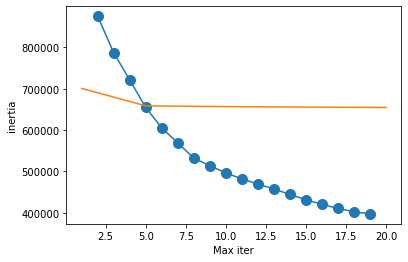

In [235]:
# looking at the clusters and inertia of the model
kmeans.cluster_centers_
kmeans.inertia_
# understand the cluster
clusters = kmeans.predict(X_prep)
len(clusters)
# adding clusters to our dataframe
X_df = pd.DataFrame(X)
X_df['cluster'] = clusters

# I visulised the model:

# 1. to understand my best number the 
# I want to iterate over a range of n_clusters and for every value, I want to return the inertia
def get_kmeans_inertia_varying_cluster_n(n_clusters):
    
    # setup the model
    kmeans = KMeans(n_clusters=n_clusters,
                    random_state=123,
                    n_init=3,
                    #algorithm='elkan',
                   )
    # train the model
    kmeans.fit(X_prep_df)
    
    # return the resulting inertia
    return kmeans.inertia_

# Plot for a range of cluster numbers
import matplotlib.pyplot as plt

cluster_range = range(2,20)

plt.plot(cluster_range,
         [get_kmeans_inertia_varying_cluster_n(c_number) for c_number in cluster_range],
         marker="o",
         ms=10,
        )
plt.xlabel('Cluster Number')
plt.ylabel('inertia')

# I want to iterate over a range of mx_iter and for every value, I want to return the inertia
def get_kmeans_ineratia_varying_max_iter(max_iter):
    kmeans = KMeans(n_clusters=5,
                    random_state=123,
                    n_init=3,
                    algorithm='elkan',
                    max_iter=max_iter,
                   )
    kmeans.fit(X_prep_df)

    return kmeans.inertia_

max_iter_list = [1, 5, 10, 20]

plt.plot(max_iter_list,
         [get_kmeans_ineratia_varying_max_iter(x) for x in max_iter_list],
        )
plt.xlabel('Max iter')
plt.ylabel('inertia')

In [236]:
### put the datframe together
mvp = pd.concat([X_df['cluster'],df[['artist_name','track_name','track_id']]],axis = 1)

In [253]:
mvp.head()

,cluster,artist_name,track_name,track_id
0,38,YG,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",2RM4jf1Xa9zPgMGRDiht8O
1,95,YG,BAND DRUM (feat. A$AP Rocky),1tHDG53xJNGsItRA3vfVgs
2,16,R3HAB,Radio Silence,6Wosx2euFPMT14UXiWudMy
3,83,Chris Cooq,Lactose,3J2Jpw61sO7l6Hc7qdYV91
4,25,Chris Cooq,Same - Original mix,2jbYvQCyPgX3CdmAzeVeuS


### Importing the libraries

In [237]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from getpass import getpass
from tqdm.notebook import tqdm
import pandas as pd
import joblib
from time import sleep
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# set clientID and client secret in global variables
import getpass 
clientid = 'c4018e09bee04ef089bc8869128a8d59'
clientsecret = getpass.getpass() 

### definifng the input function

### creating function for a dataframe of songs where input matches a song 

In [239]:
def songs_matching_inp(inp,song,artists,songid):
    
    # We create a list of songs where the inputted string matches
    matches = song.str.lower().str.find(inp.lower())
    songs = [(song[i],artists[i],songid[i]) for i,x in enumerate(matches) if x>=0]
    
    # If there is no matches whatsoever we return false, if any match, return songs list 
    if len(songs)==0:
        return None
    else:
        return songs

### function to select the songs in the list

In [240]:
def select_song(songs):
    
    if len(songs)==1:    
        print("\nDid you mean this song?")
    else:
        print("\nDid you mean any of these?")
        
    # displaying the options and ask for selection
    for i,song in enumerate(songs):
        print("{}-> {} | {}".format(str(i),song[0],song[1]))   
    
    sel = input("If yes, choose song number. if not, type N0: ").strip()
    
    #we use try/except to raise errors if the index is out of range, or if the input can't be converted to an int 
    while sel.lower()!="no":
        try:
            chose = songs[int(sel)]
            sleep(.5)
            print("You chose:\n{} | {} ".format(chose[0],chose[1]))
            return chose[2]
        except ValueError:
            sel = input("Sorry, I didn't understand! Choose number if yes, N if not.").strip()
        except IndexError:
            sel = input("Please choose one of the songs or write N if not: ").strip()
    
    return False 

In [241]:
def hot_songs():
    inp = str(input("Insert the name of a hot song: ")).strip()
    
    """
    This function checks if the songs match from the hot songs list. If there is no match it will return the input string.
    If there is a match, it will return a dataframe with up to 10 songs that match, to give back recommendations
    """
    hot_100 = pd.read_csv("Billboard.csv", index_col=0)
    
    matching = songs_matching_inp(inp,hot_100['song'],hot_100['artist'],hot_100['rank'])
    
    if matching == None:
        return inp
    else:
        song_ind = select_song(matching)
    
    if song_ind == False:
        return inp
    else:
        out = hot_100[hot_100['rank']!=song_ind][['song','artist','rank']]
        out.rename(columns = {'song': 'name', 'artist': 'artists','rank':'id'}, inplace = True)
        return  out.sample(10)
        

### Song query

query songs from a spotify search, 
and return a list of songs to ask the user to confirm what they searched for

In [242]:
def spotify_query(inp,offs = 0):
    tracks_query = sp.search(str(inp), limit=10, type='track', offset=offs)['tracks']['items']    #queries 10 song names to spotify api
    songs = []
    for track in tracks_query:
        sp_song = track['name']
        sp_artists = ", ".join([artist['name'] for artist in track['artists']])
        sp_id = track['id']
        songs.append((sp_song,sp_artists,sp_id))
    return songs
    

In [243]:
def spotify_inp(inp):
    """
    Used to send the query, and make the user select which song
    """
    #Tis can be improved to roll in various pages of the query, or by asking a new input
    sp_songs = spotify_query(inp)
    
    selection = select_song(sp_songs)

    return selection

### Spotiy recommender

In [244]:
def spotify_recommender(song_id):
    """
    Brings over the model and the scaler in order to find the cluster it belongs to, and return a recommendation list of songs
    that belong to the same cluster.
    """
    #loading the model and the cluster-song list
    model = kmeans #kmeans
    cluster_id = mvp #mvp
    
    #retrieve the features from api
    song_feats = sp.audio_features(song_id)[0]
    features = ['danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence'] 
    result = pd.DataFrame({key:song_feats[key] for key in features},index = [0])
    
    #we scale it with our scaler 
    scaled_feat = scaler.transform(result)
    
    #we predict to which cluster it belongs
    clust_pred = model.predict(scaled_feat)[0]
    
    #and create a 10 song sample id list from songs in the same category
    songs_category = cluster_id[cluster_id['cluster']==clust_pred]
    recomm = songs_category.sample(10)[['name','artists','id']]
    
    return recomm

In [275]:
from time import sleep
from IPython import display
s=display.Image('https://storage.googleapis.com/pr-newsroom-wp/1/2019/12/Spotify_discovering_music_R4.gif')
def print_recommendation(recomm):
    """
    Prints the recommendation
    """
    
    for i,song_id in enumerate(recomm['id']):
        song = recomm['name'].iloc[i]
        artist = recomm['artists'].iloc[i]
        sleep(1)
        print("\nYour Recommendation:\n{} | {} ".format(song,artist))
        
        sleep(2)
        if i != len(recomm['id'])-1:
            a = input("Would you like one more suggestion? Y/N: ")
            if a.lower() == "n":
                print("\n ENJOY ")
                return False 
    return True


In [278]:
def Music_recommender():
    inp = str(input("Insert the name of a hot song: ")).strip()
    recomm = hot_songs()                          # check if a hot song
    
    if isinstance(recomm,str):                    # check in spotify if not in billboard
        song_id = spotify_inp(inp)                # get the input, return the song ID
        in_cluster = spotify_recommender(song_id) # retrieve the features.
        recomm = in_cluster
    print_recommendation(recomm)
    

In [279]:
Music_recommender()

Insert the name of a hot song: leave the door open
Insert the name of a hot song: leave the door open

Did you mean this song?
0-> Leave The Door Open | Silk Sonic (Bruno Mars & Anderson .Paak)
If yes, choose song number. if not, write N: 0
You chose:
Leave The Door Open | Silk Sonic (Bruno Mars & Anderson .Paak) 

Your Recommendation:
Chasing After You | Ryan Hurd With Maren Morris 
Would you like one more suggestion? Y/N: Y

Your Recommendation:
Follow You | Imagine Dragons 
Would you like one more suggestion? Y/N: Y

Your Recommendation:
pride.is.the.devil | J. Cole & Lil Baby 
Would you like one more suggestion? Y/N: Y

Your Recommendation:
Montero (Call Me By Your Name) | Lil Nas X 
Would you like one more suggestion? Y/N: Y

Your Recommendation:
Best Friend | Saweetie Featuring Doja Cat 
Would you like one more suggestion? Y/N: N

 ENJOY 


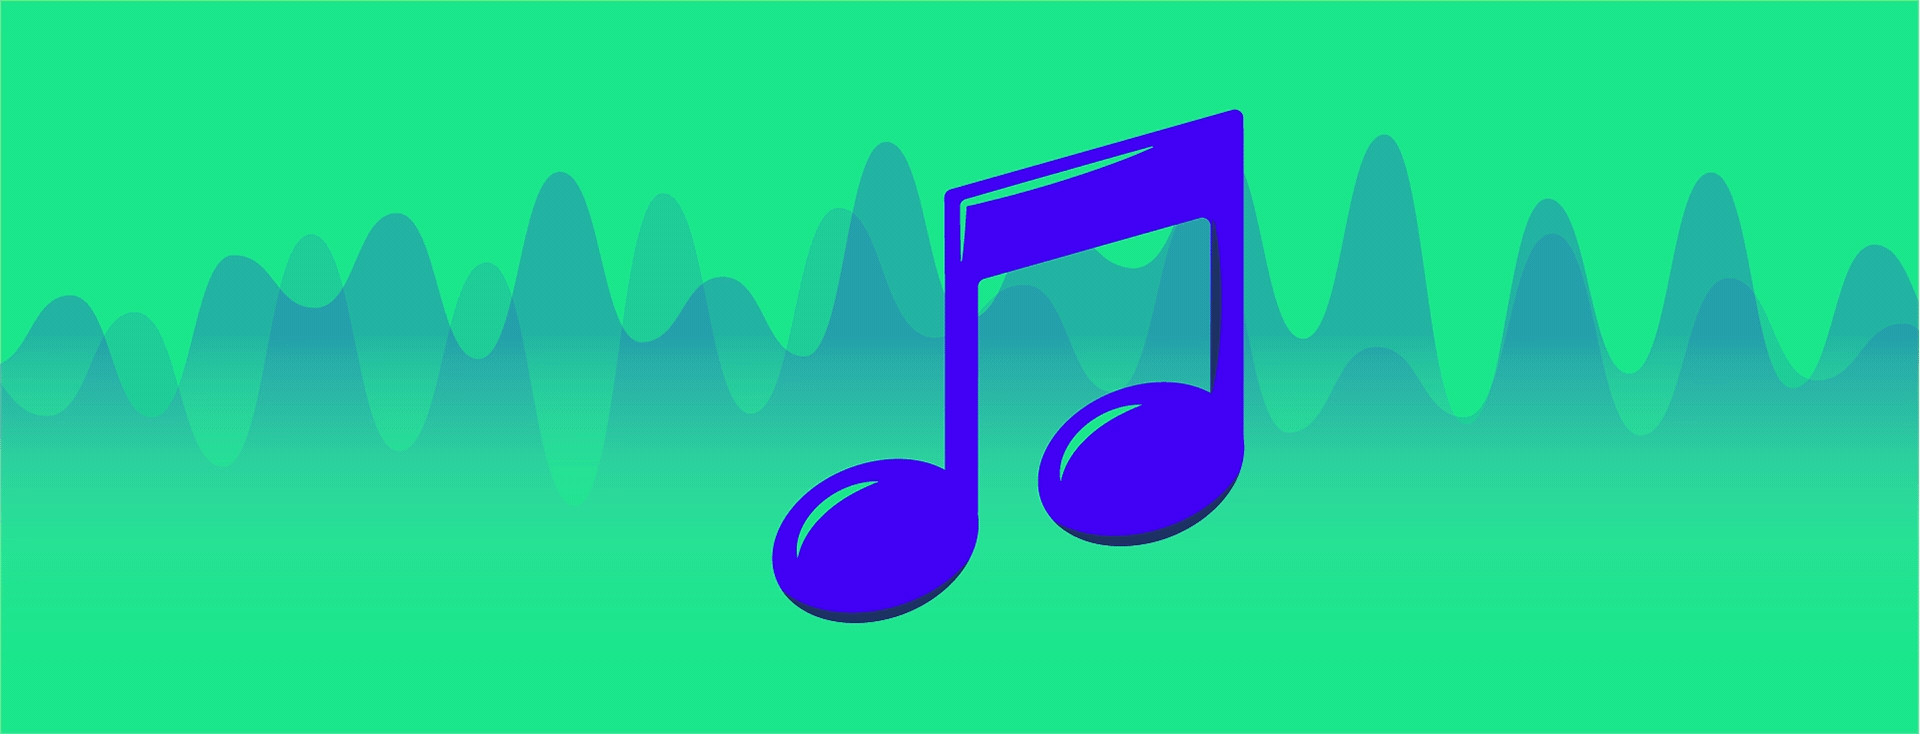

In [280]:
s